In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

In [24]:
PATH = 'data/spooky'

os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

bs = 64
bptt = 70

emb_sz = 200       # size of each embedding vector
nh = 500           # of hidden activations per layer
nl = 3             # of layers

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [10]:
train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/train.csv')

In [11]:
# tokenize = split each sentence into a list of words
' '.join(spacy_tok(train_df.text.iloc[0]))

'This process , however , afforded me no means of ascertaining the dimensions of my dungeon ; as I might make its circuit , and return to the point whence I set out , without being aware of the fact ; so perfectly uniform seemed the wall .'

In [12]:
#createa torchtext field = describes how to preprocess a piece of text
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [13]:
FILES = dict(train_df=train_df, val_df=train_df, test_df=test_df)

# min_freq = 10 says, "treat any word that appears less than 10 times as the word <unk>"
md = LanguageModelData.from_dataframes(PATH, TEXT, 'text', **FILES, bs=bs, bptt=bptt, min_freq=10)

In [15]:
# after building the ModelData object, TEXT.vocab is set.  because this will be needed again, save it
pickle.dump(TEXT, open(f'{PATH}/models/TEXT.pkl', 'wb'))

In [17]:
# batches, # of unique tokens in vocab, # of items in ds, # of words in ds
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(131, 4930, 1, 595187)

In [18]:
# int to string mapping
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was']

In [19]:
# string to int mapping
TEXT.vocab.stoi['the']

3

In [20]:
# in a LanguageModelData object there is only one item in each dataset: all the words joined together
md.trn_ds[0].text[:12]

['this',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the']

In [21]:
# torchtext will handle turning this words into integer Ids
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
   31
 3075
    2
  153
    2
 1385
   27
   42
  304
    4
    0
    3
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [22]:
batch = next(iter(md.trn_dl))
print(batch[0].size()), print(batch[1].size())

batch

torch.Size([65, 64])
torch.Size([4160])


(Variable containing:
    31     9    81  ...    113     3     0
  3075     0    23  ...      3  4206     5
     2     2   912  ...      0  3940    12
        ...          ⋱          ...       
     5     0   241  ...     52   729     3
    10     5    29  ...     11     2  3262
    20    26   428  ...     62    41     4
 [torch.cuda.LongTensor of size 65x64 (GPU 0)], Variable containing:
  3075
     0
    23
   ⋮  
     0
    26
     3
 [torch.cuda.LongTensor of size 4160 (GPU 0)])

In [25]:
learner = md.get_model(opt_fn, emb_sz, nh, nl,
                      dropouti=0.24, dropout=0.025, wdrop=0.05, dropoute=0.01, dropouth=0.025)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [26]:
lrf = learner.lr_find() 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 127/131 [00:34<00:01,  3.70it/s, loss=30.2]

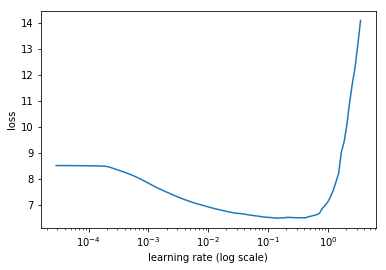

In [27]:
learner.sched.plot()

In [30]:
lr = 3e-3

In [31]:
learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2) # ran this with lr 1e-3 first, then 3e-3

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       4.6463   4.53393]                                
[ 1.       4.61321  4.45506]                                
[ 2.       4.47622  4.37042]                                
[ 3.       4.50426  4.3332 ]                                
[ 4.       4.38605  4.19747]                                
[ 5.       4.26417  4.08503]                                
[ 6.       4.18938  4.03555]                                
[ 7.       4.29203  4.07714]                                
[ 8.       4.20329  3.99213]                                
[ 9.       4.1106   3.87906]                                
[ 10.        3.98029   3.73345]                             
[ 11.        3.87576   3.61111]                             
[ 12.        3.78729   3.51501]                             
[ 13.        3.71843   3.45879]                             
[ 14.        3.6955    3.40579]                             



In [32]:
learner.save_encoder('spooky_adam1_enc')
# learner.load_encoder('spooky_adam1_enc')

In [33]:
learner.fit(lr, 4, wds=1e-6, cycle_len=10, cycle_save_name='spooky_adam2_4_10')

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

[ 0.       3.79579  3.63839]                                
[ 1.       3.83006  3.62119]                                
[ 2.       3.74267  3.45128]                                
[ 3.       3.66159  3.38081]                                
[ 4.       3.56604  3.25719]                                
[ 5.       3.50778  3.1649 ]                                
[ 6.       3.36879  3.01657]                                
[ 7.       3.33997  2.96337]                                
[ 8.       3.37375  2.90768]                                
[ 9.       3.27448  2.85712]                                
[ 10.        3.53782   3.18202]                             
[ 11.        3.52156   3.16522]                             
[ 12.        3.44812   3.06416]                             
[ 13.        3.37365   2.95964]                             
[ 14.        3.27971   2.8554 ]                             
[ 15.        3.2204    2.76066]                             
[ 16.        3.13809   2

In [34]:
learner.save_encoder('spooky_adam2_enc')
# learner.load_encoder('spooky_adam2_enc')

In [35]:
learner.fit(lr, 1, wds=1e-6, cycle_len=20, cycle_save_name='spookey_adam2_1_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

[ 0.       2.69332  2.049  ]                                
[ 1.       3.02628  2.4751 ]                                
[ 2.       3.09508  2.58615]                                
[ 3.       3.04615  2.42488]                                
[ 4.       3.0047   2.38843]                                
[ 5.       2.95109  2.32691]                                
[ 6.       2.89743  2.29224]                                
[ 7.       2.86429  2.24553]                                
[ 8.       2.82866  2.18072]                                
[ 9.       2.7324   2.14896]                                
[ 10.        2.67861   2.04331]                             
[ 11.        2.73464   2.02844]                             
[ 12.        2.59416   1.90791]                             
[ 13.        2.65166   1.89058]                             
[ 14.        2.6118    1.84354]                             
[ 15.        2.49329   1.79262]                             
[ 16.        2.5126    1

In [36]:
learner.load_cycle('spookey_adam2_1_20', 0)

In [37]:
learner.save_encoder('spooky_adam3_enc')

In [38]:
# metric perplexity (how language model accuracy generally measured) = exp() of loss functino
np.exp(1.69678)

5.4563496287293161

## Test

In [43]:
# create a short bit of text to "prime" the precitions, then use torchtext to numericalize it
# so we can feed it into our language model
m = learner.model
ss = """. It was a dark and scary night. The old"""
s = [spacy_tok(ss)]
t = TEXT.numericalize(s)
' '.join(s[0])

'. It was a dark and scary night . The old'

In [44]:
m[0].bs = 1      # set batch size = 1
m.eval()         # turn-off dropout
m.reset()        # reset hidden state
res, *_ = m(t)   # get predictions from model
m[0].bs = bs     # put batch size back to what it was

In [45]:
# top 10 predictions for next word
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['bugs',
 '<unk>',
 'men',
 'wretch',
 'devils',
 'folks',
 'creatures',
 'folk',
 'man',
 'l.']

In [46]:
# try to generate more text
print(ss, "\n")

for i in range(50):
    n = res[-1].topk(2)[1]
    n = n[1] if n.data[0] == 0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res, *_ = m(n[0].unsqueeze(0))
    
print('...')

. It was a dark and scary night. The old 

bugs , the son of the old old gentlemen , was born in the beginning of making two two hours , and in the meantime he had found him at the door of the house . it was a painful point , and i did not sleep well . it ...


## Predict the author

In [ ]:
bs = 64
bptt = 70

emb_sz = 200       # size of each embedding vector
nh = 500           # of hidden activations per layer
nl = 3             # of layers

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [ ]:
# use the same vocab built from the language model so as to ensure words map to same Ids
TEXT = pickle.load(open(f'{PATH}/models/TEXT.pkl', 'rb'))

In [ ]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

In [ ]:
t = splits[0].examples[0]

In [ ]:
t.label, ' '.join(t.text[:10])

In [ ]:
# fastai can create a ModelData object directly from torchtext splits
md2 = TextData.from_splits(PATH, splits, bs)

In [ ]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=emb_sz, n_hid=nh, n_layers=nl,
                      dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'imdb_adam2_enc')

In [ ]:
m3.clip = 25.
lrs = np.array([1e-4, 1e-3, 1e-2])

In [ ]:
m3.freeze_to(-1) # freeze everything except last layer
m3.fit(lrs/2, 1, metrics=[accuracy])

In [ ]:
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb_sent1_c7_cl2')